# Workflow
Jupyter notebook created to visualize the ML process of extracting and manipulating NCSS data, plus model fitting and evaluation. All with the TerrasenseTK python toolkit

### Libraries

In [1]:
from eolearn.core import FeatureType
import matplotlib.pyplot as plt
import terrasensetk as tstk
import seaborn as sns
import pandas as pd
import numpy as np
import folium

## Data science

### Dataset creation

In [2]:
eopatches_path = './EOPatches/landsat-4-5-TM'
# Gets dataset
dataset = tstk.Dataset(eopatches_path)
parser = tstk.Parser(dataset)
print(f'Extracted: {len(dataset.get_tspatches())} TSPatches')

Extracted: 1149 TSPatches


#### Checking nan

Bands are never nan, as tstk only saves bands with values.

Indices however, might be, as they result from the calculation of bands, which can be 0.0 

In [3]:
#! run twice
# Check and remove any TSPatch has missing band data
count = 0
for tsp in parser.get_tspatches():
    for indice in parser.get_indices():
        if np.isnan(tsp.eopatch[(FeatureType.DATA, indice)]).any():
            count += 1
            parser.get_tspatches().remove(tsp)

quantity = len(parser.get_tspatches())
print(f'Removed {count} tsp')

Removed 0 tsp


##### Adding new indices

Added a lot of indices that seem relevant. Gathering all options and then discarding them

In [ ]:
# Adding new indices
bands = dataset.get_bands()
dataset.add_indices({
    # Chlorophyll Green
    'Chlgreen': lambda b: (b[bands['B:VNIR7']] / b[bands['B:RED']]) ** -1,
    # Chlorophyll Index Green:
    'CIG': lambda b: b[bands['B:VNIR8a']] / b[bands['B:GREEN']] - 1,
    # Ferric iron  
    'FE2': lambda b: (b[bands['B:SWIR12']] / b[bands['B:VNIR8']]) + (b[bands['B:GREEN']] / b[bands['B:RED']]),
    # Modified Chlorophyl absorption in reflectance index 1
    'MCARI': lambda b: 1.2*(2.5*(b[bands['B:VNIR8']] - b[bands['B:RED']]) - 1.3*(b[bands['B:VNIR8']] - b[bands['B:GREEN']])),
    })

####

In [4]:
parser.create_df()
df = parser.get_df()
print(df.shape)
df.head(3)

(1149, 29)


,ID,LOC,MSAVI,EVI,SAVI,CVI,NDVI,NDMI,B:BLUE,B:GREEN,...,Mo,Z,pH,P,K,Ca,Mg,Fe,Mn,Cec
0,eopatch_00P00001,0 POINT (40.76870 -73.97919) Name: geometry...,"[0.5698043, 0.5038654, 0.5112374, 0.5038654]","[0.46670774, 0.41327223, 0.42133197, 0.4212811]","[0.55091435, 0.5028424, 0.5083255, 0.5028424]","[7.3603997, 5.670537, 5.35079, 5.678344]","[0.8342339, 0.82829446, 0.81631577, 0.82829446]","[0.3560361, 0.33924827, 0.34087375, 0.2893566]","[0.02682, 0.0289925, 0.02682, 0.024675]","[0.039965, 0.0399925, 0.04431, 0.039965]",...,NaN,116.08,4.5,761.583333,5364.9,2366.74,1904.316,14573.0,160.78,7.535
1,eopatch_84P03288,0 POINT (36.17448 -108.58482) Name: geometr...,"[0.082339354, 0.07771203, 0.0793805, 0.08108534]","[0.040405292, 0.038378485, 0.038808364, 0.0402...","[0.08802995, 0.08343869, 0.08459998, 0.08721112]","[1.911351, 1.978983, 1.9504431, 1.9769073]","[0.10463069, 0.10025353, 0.09954332, 0.1054585]","[-0.12880531, -0.14521497, -0.12213416, -0.145...","[0.1421825, 0.1393225, 0.1421825, 0.1378925]","[0.229715, 0.2203925, 0.23285, 0.2172575]",...,NaN,NaN,8.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,eopatch_84P03762,0 POINT (34.99284 -108.07674) Name: geometr...,"[0.16258374, 0.1722968, 0.14310534, 0.13838556]","[0.10506675, 0.11041997, 0.09127656, 0.087046094]","[0.1843703, 0.19443086, 0.16289257, 0.1572525]","[2.905202, 2.9871547, 2.707762, 2.6987681]","[0.29028174, 0.3029669, 0.25440228, 0.24227485]","[-0.0019117547, -0.0071181958, 0.031516526, -0...","[0.069005, 0.0718925, 0.070435, 0.0733225]","[0.1030775, 0.1030775, 0.10943, 0.11262]",...,NaN,NaN,6.6,NaN,NaN,NaN,NaN,NaN,NaN,22.700


### Data profiling

#### Managing features


What would be fed into the model as X

In [5]:
print(df.shape)
df[parser.get_features()].head(3)

(1149, 29)


,MSAVI,EVI,SAVI,CVI,NDVI,NDMI,B:BLUE,B:GREEN,B:RED,B:NIR,B:SWIR5,B:THERMAL,B:SWIR7
0,"[0.5698043, 0.5038654, 0.5112374, 0.5038654]","[0.46670774, 0.41327223, 0.42133197, 0.4212811]","[0.55091435, 0.5028424, 0.5083255, 0.5028424]","[7.3603997, 5.670537, 5.35079, 5.678344]","[0.8342339, 0.82829446, 0.81631577, 0.82829446]","[0.3560361, 0.33924827, 0.34087375, 0.2893566]","[0.02682, 0.0289925, 0.02682, 0.024675]","[0.039965, 0.0399925, 0.04431, 0.039965]","[0.032595, 0.029185, 0.032595, 0.029185]","[0.36067, 0.3107575, 0.3223075, 0.3107575]","[0.1712775, 0.15332, 0.158435, 0.1712775]","[310.2075, 309.55466, 310.2075, 309.55466]","[0.065705, 0.0584175, 0.065705, 0.0693625]"
1,"[0.082339354, 0.07771203, 0.0793805, 0.08108534]","[0.040405292, 0.038378485, 0.038808364, 0.0402...","[0.08802995, 0.08343869, 0.08459998, 0.08721112]","[1.911351, 1.978983, 1.9504431, 1.9769073]","[0.10463069, 0.10025353, 0.09954332, 0.1054585]","[-0.12880531, -0.14521497, -0.12213416, -0.145...","[0.1421825, 0.1393225, 0.1421825, 0.1378925]","[0.229715, 0.2203925, 0.23285, 0.2172575]","[0.285925, 0.28037, 0.294285, 0.2747875]","[0.35275, 0.34285, 0.35935, 0.3395775]","[0.4570575, 0.45934, 0.45934, 0.454775]","[314.10062, 314.10062, 314.10062, 314.10062]","[0.411545, 0.405055, 0.4148175, 0.4083]"
2,"[0.16258374, 0.1722968, 0.14310534, 0.13838556]","[0.10506675, 0.11041997, 0.09127656, 0.087046094]","[0.1843703, 0.19443086, 0.16289257, 0.1572525]","[2.905202, 2.9871547, 2.707762, 2.6987681]","[0.29028174, 0.3029669, 0.25440228, 0.24227485]","[-0.0019117547, -0.0071181958, 0.031516526, -0...","[0.069005, 0.0718925, 0.070435, 0.0733225]","[0.1030775, 0.1030775, 0.10943, 0.11262]","[0.1303025, 0.1303025, 0.1388275, 0.1444925]","[0.2368925, 0.243575, 0.233565, 0.2368925]","[0.2378, 0.2470675, 0.2192925, 0.2378]","[316.10358, 316.107, 316.68805, 316.68805]","[0.182855, 0.196, 0.17631, 0.186155]"


Check if all X are ndarray

In [6]:
df[parser.get_features()].map(lambda entry: not isinstance(entry, np.ndarray)).sum()

MSAVI        0
EVI          0
SAVI         0
CVI          0
NDVI         0
NDMI         0
B:BLUE       0
B:GREEN      0
B:RED        0
B:NIR        0
B:SWIR5      0
B:THERMAL    0
B:SWIR7      0
dtype: int64

Being X the whole feature data, and x one datapoint of X, ML models accept 3 or 1 band.

So x must be converted from [F1, F2, ...], to F_i as a single value.

To represent each feature as a single value, each feature was reduced to its mean.

In [7]:
df.loc[:, parser.get_features()] = df[parser.get_features()].map(np.mean)
df.head(3)

,ID,LOC,MSAVI,EVI,SAVI,CVI,NDVI,NDMI,B:BLUE,B:GREEN,...,Mo,Z,pH,P,K,Ca,Mg,Fe,Mn,Cec
0,eopatch_00P00001,0 POINT (40.76870 -73.97919) Name: geometry...,0.522193,0.430648,0.516231,6.015018,0.826785,0.331379,0.026827,0.041058,...,NaN,116.08,4.5,761.583333,5364.9,2366.74,1904.316,14573.0,160.78,7.535
1,eopatch_84P03288,0 POINT (36.17448 -108.58482) Name: geometr...,0.080129,0.039465,0.08582,1.954421,0.102472,-0.135294,0.140395,0.225054,...,NaN,NaN,8.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,eopatch_84P03762,0 POINT (34.99284 -108.07674) Name: geometr...,0.154093,0.098452,0.174737,2.824722,0.272481,0.005144,0.071164,0.107051,...,NaN,NaN,6.6,NaN,NaN,NaN,NaN,NaN,NaN,22.700


#### Managing labels
What the Experiment can use as label. We only intend to predict nutrient values

In [8]:
df[parser.get_groundtruth_f()].head(3)

,C,N,S,Cu,Mo,Z,pH,P,K,Ca,Mg,Fe,Mn,Cec
0,68700.0,2820.0,1000.0,70.88,NaN,116.08,4.5,761.583333,5364.9,2366.74,1904.316,14573.0,160.78,7.535
1,NaN,NaN,NaN,NaN,NaN,NaN,8.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,6.6,NaN,NaN,NaN,NaN,NaN,NaN,22.700


All are nutrient, except pH and Cec, but can also be used to evaluate soil

Convert all to numeric, or nan

In [9]:
df.loc[:, parser.get_groundtruth_f()] = df[parser.get_groundtruth_f()].apply(lambda x: pd.to_numeric(x, errors='coerce'))

In [10]:
df[parser.get_groundtruth_f()].dtypes

C      float64
N      float64
S      float64
Cu     float64
Mo     float64
Z      float64
pH     float64
P      float64
K      float64
Ca     float64
Mg     float64
Fe     float64
Mn     float64
Cec    float64
dtype: object

And count how many are labeled and unlabeled. X_l and X_u, respectively

In [11]:
pd.DataFrame(data=(df[parser.get_groundtruth_f()].count(), quantity - df[parser.get_groundtruth_f()].count()),
             index=['X_l', 'X_u'])

,C,N,S,Cu,Mo,Z,pH,P,K,Ca,Mg,Fe,Mn,Cec
X_l,501,791,338,248,177,230,1136,466,1138,1138,1138,583,811,1121
X_u,648,358,811,901,972,919,13,683,11,11,11,566,338,28


In [46]:
df[parser.get_groundtruth_f()].describe()

,C,N,S,Cu,Mo,Z,pH,P,K,Ca,Mg,Fe,Mn,Cec
count,501.000000,791.000000,338.000000,248.000000,177.000000,230.000000,1136.000000,466.000000,1138.000000,1138.000000,1138.000000,583.000000,811.000000,1121.000000
mean,71674.251497,2801.807838,829.585799,33.142379,0.264181,151.863043,5.972799,490.456491,2367.938445,8719.381610,1712.453589,10684.772154,591.520006,12.372649
std,125557.396579,4014.068947,2822.274764,77.906929,2.736833,515.374828,1.245825,440.674375,3772.165909,11128.679441,3532.082029,11103.997398,697.784583,14.147746
min,200.000000,30.000000,0.000000,1.280000,-5.370000,7.080000,2.700000,0.000000,0.000000,20.040000,0.000000,0.000000,0.000000,1.105000
25%,12700.000000,875.000000,100.000000,13.010000,-0.330000,49.980000,5.000000,73.500000,152.100000,2791.572000,413.273750,2375.000000,180.166500,5.960000
50%,24000.000000,1480.000000,200.000000,19.040000,0.020000,73.880000,5.900000,419.870000,382.200000,5525.028000,900.500000,7400.000000,386.720000,8.965000
75%,49200.000000,2655.000000,600.000000,34.185000,0.520000,105.832500,7.100000,723.015000,3063.625000,10834.296000,1963.720750,15052.750000,753.594500,13.485000
max,568500.000000,23460.000000,33100.000000,1135.840000,32.110000,4873.130000,10.000000,2538.000000,21499.000000,158852.912000,81119.460000,69576.000000,7414.065000,138.200000


K, Ca, Mg and pH are useful to test if the amount of labeled data is enough to create a good SL model.

All the others can be used to evaluate if SSL has a better outcome.

Note than X is too smal, and so mostlikely no model will be good

#### Data distribution

Calculate basic statistics such as mean, median, standard deviation, minimum, and maximum for numerical attributes.

In [15]:
df[parser.get_features()] = df[parser.get_features()].astype(float)
df[parser.get_bands().keys()].describe()

,B:BLUE,B:GREEN,B:RED,B:NIR,B:SWIR5,B:THERMAL,B:SWIR7
count,1149.000000,1149.000000,1149.000000,1149.000000,1149.000000,1149.000000,1149.000000
mean,0.096010,0.117341,0.132900,0.278997,0.257089,300.666440,0.174171
std,0.206683,0.146264,0.181341,0.142596,0.125344,18.341130,0.098567
min,0.007666,0.011805,0.007357,0.023245,0.005700,150.001480,0.001429
25%,0.039106,0.063244,0.060666,0.209008,0.183206,294.462402,0.096161
50%,0.062391,0.090771,0.100864,0.254472,0.250065,302.115326,0.160278
75%,0.087224,0.125256,0.149112,0.312421,0.320437,310.504852,0.237326
max,1.602213,1.602213,1.602213,1.602213,1.602213,329.458649,0.801055


In [16]:
df[parser.get_indices()].describe()

,MSAVI,EVI,SAVI,CVI,NDVI,NDMI
count,1149.000000,1149.000000,1149.000000,1149.000000,1149.000000,1149.000000
mean,0.238882,0.177097,0.255135,3.171124,0.417130,0.047726
std,0.168023,0.136829,0.157931,1.253641,0.239488,0.212735
min,-0.532755,-0.107679,-0.428618,0.481558,-0.345747,-0.345153
25%,0.124177,0.074233,0.141402,2.254412,0.217630,-0.125625
50%,0.192674,0.134826,0.219084,2.899851,0.385016,0.000762
75%,0.331616,0.249302,0.354077,3.834004,0.601758,0.203622
max,0.805791,0.691128,0.737302,9.701960,0.920096,0.734509


Plot data ditribution

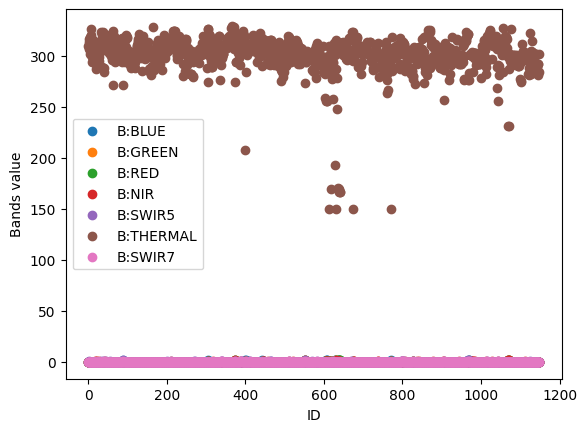

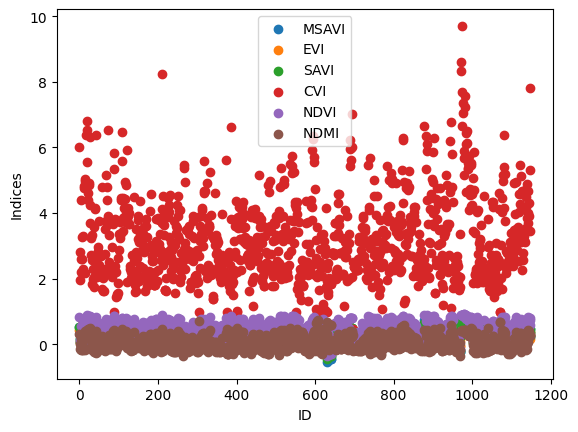

In [17]:

for band in parser.get_bands().keys():
    plt.scatter(df.index, df[band], label=band)
# Add labels and legend
plt.xlabel('ID')
plt.ylabel('Bands value')
plt.legend()
# Show the plots
plt.show()

for indice in parser.get_indices():
    plt.scatter(df.index, df[indice], label=indice)
# Add labels and legend
plt.xlabel('ID')
plt.ylabel('Indices')
plt.legend()
# Show the plots
plt.show()

and boxplots

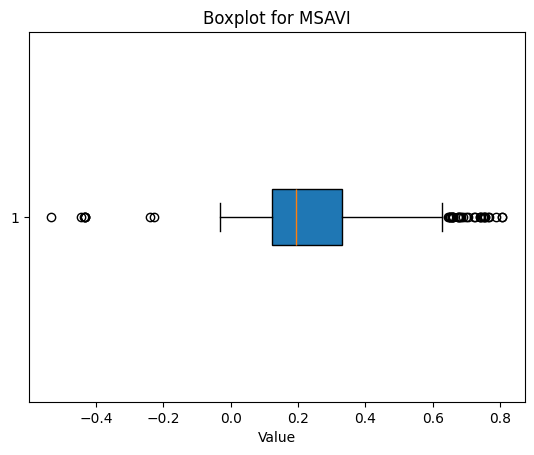

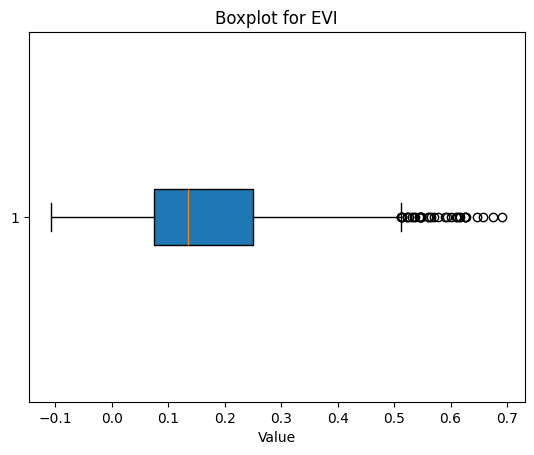

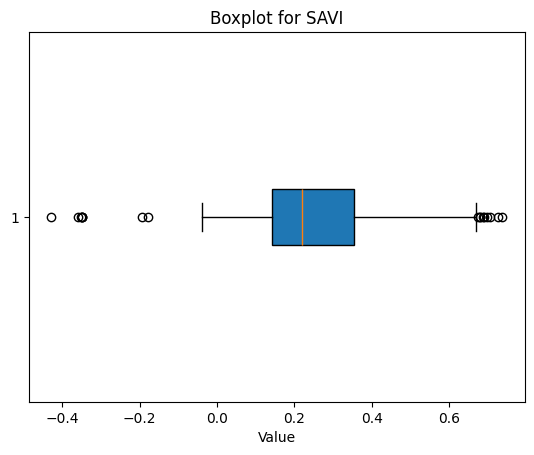

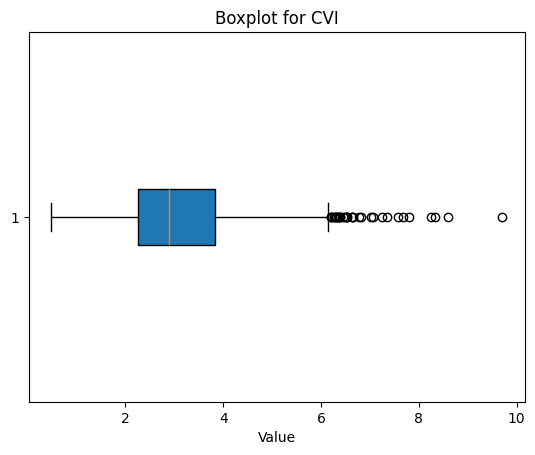

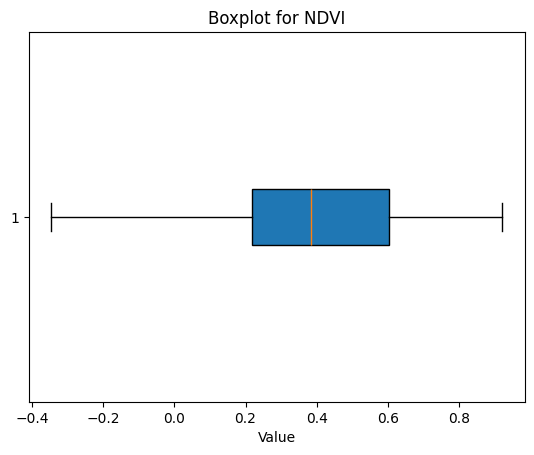

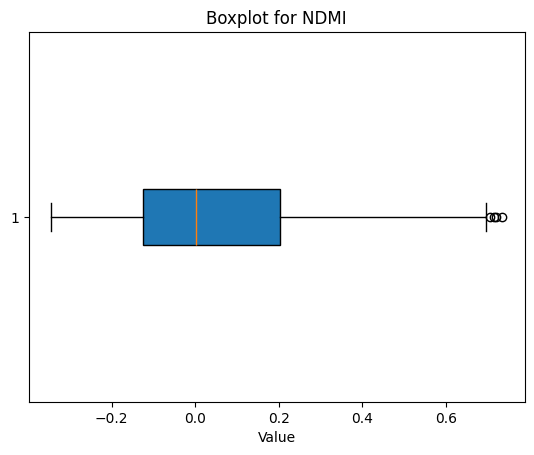

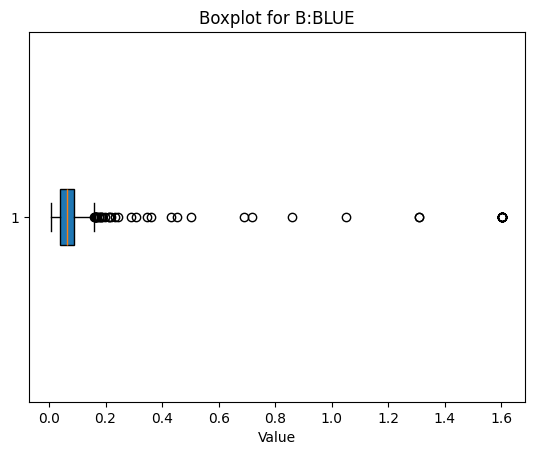

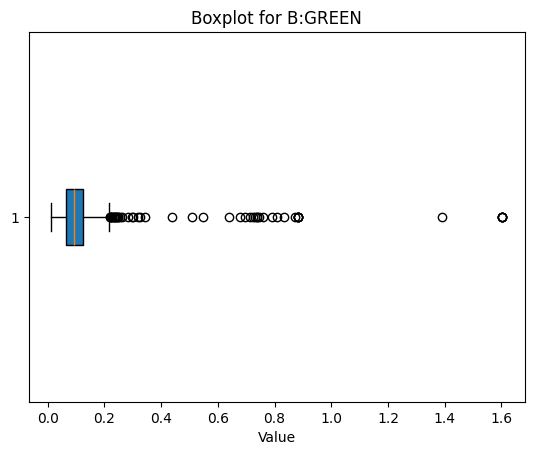

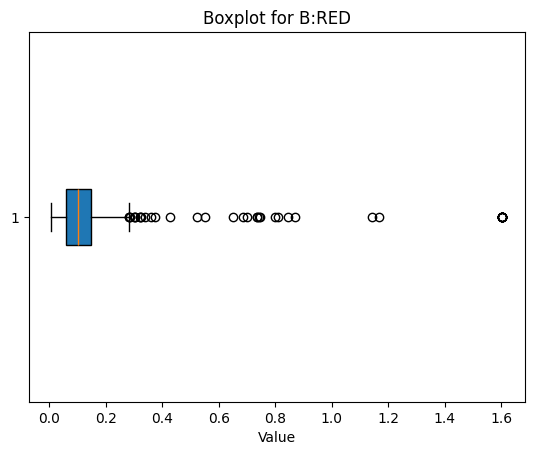

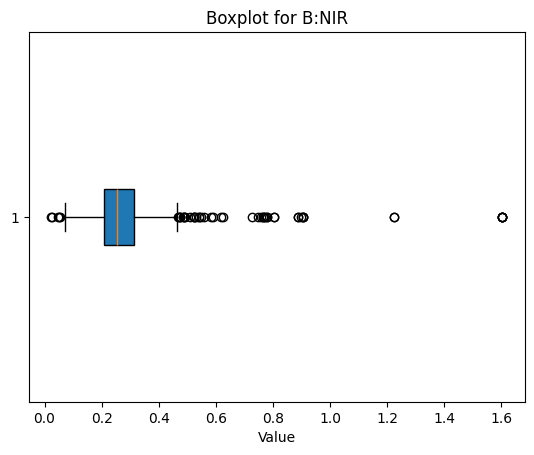

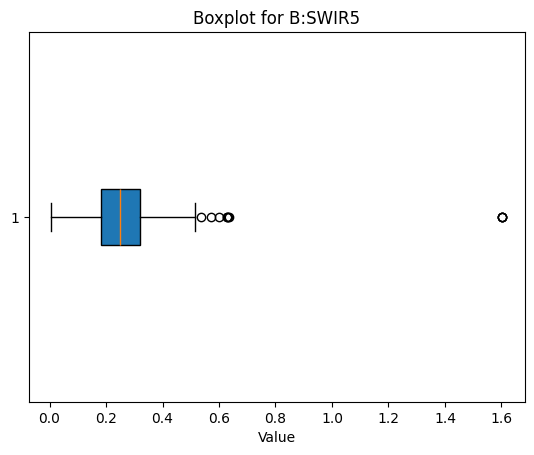

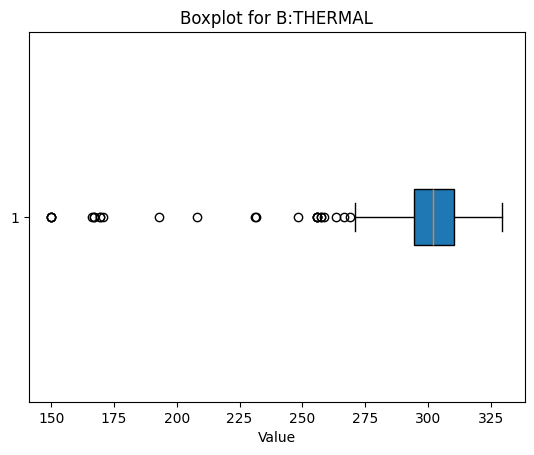

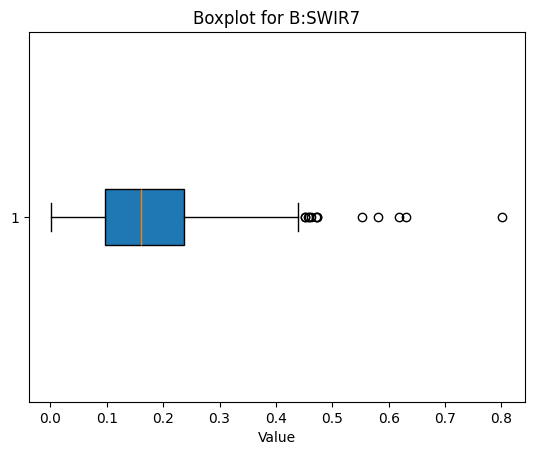

In [44]:
for feature in parser.get_features():
    plt.figure()
    # Create a boxplot and obtain the summary statistics
    bp = plt.boxplot(df[feature], vert=False, patch_artist=True)
    plt.title(f'Boxplot for {feature}')
    plt.xlabel('Value')

plt.show()

#### Feature relationship

##### Correlation of features

In [18]:
corr_threshold = 0.8

corr_df = df[parser.get_indices() + list(parser.get_bands().keys())].corr()
corr_df[corr_df.abs() < corr_threshold]

,MSAVI,EVI,SAVI,CVI,NDVI,NDMI,B:BLUE,B:GREEN,B:RED,B:NIR,B:SWIR5,B:THERMAL,B:SWIR7
MSAVI,NaN,NaN,NaN,NaN,NaN,0.601602,-0.397380,-0.430411,-0.519060,0.111313,-0.370872,0.111350,-0.569524
EVI,NaN,NaN,NaN,NaN,NaN,0.689477,-0.316987,-0.382760,-0.432527,0.151576,-0.417977,-0.001576,-0.634497
SAVI,NaN,NaN,NaN,NaN,NaN,0.606225,-0.415480,-0.455924,-0.537940,0.078368,-0.398867,0.104782,-0.603494
CVI,NaN,NaN,NaN,NaN,NaN,0.586695,-0.327660,-0.414109,-0.408115,0.055681,-0.403756,0.000461,-0.604251
NDVI,NaN,NaN,NaN,NaN,NaN,0.674867,-0.421578,-0.498853,-0.557832,-0.041867,-0.547033,0.012450,-0.750194
NDMI,0.601602,0.689477,0.606225,0.586695,0.674867,NaN,0.138513,0.059744,0.013434,0.374692,-0.556378,-0.452443,-0.702819
B:BLUE,-0.397380,-0.316987,-0.415480,-0.327660,-0.421578,0.138513,NaN,NaN,NaN,0.732606,0.435967,-0.531772,0.337553
B:GREEN,-0.430411,-0.382760,-0.455924,-0.414109,-0.498853,0.059744,NaN,NaN,NaN,NaN,0.516764,-0.498800,0.469334
B:RED,-0.519060,-0.432527,-0.537940,-0.408115,-0.557832,0.013434,NaN,NaN,NaN,0.770082,0.529398,-0.522294,0.488008
B:NIR,0.111313,0.151576,0.078368,0.055681,-0.041867,0.374692,0.732606,NaN,0.770082,NaN,0.431306,-0.450422,0.255531


As expected, there is no strong correlation between Indices and Bands.

Thus we investigate them seperately

Bands correlation

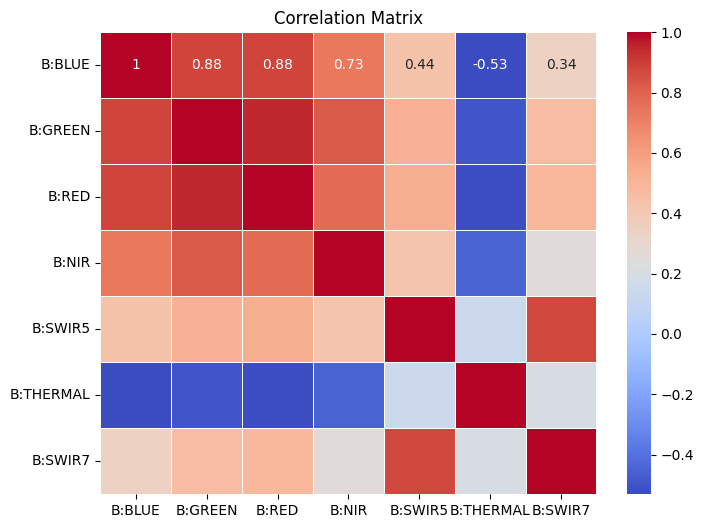

In [19]:
bands_corr_df = df[parser.get_bands().keys()].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(bands_corr_df, annot=True, cmap="coolwarm", linewidths=0.7)
plt.title("Correlation Matrix")
plt.show()

In [20]:
bands_corr_df[bands_corr_df.abs() < corr_threshold]

,B:BLUE,B:GREEN,B:RED,B:NIR,B:SWIR5,B:THERMAL,B:SWIR7
B:BLUE,NaN,NaN,NaN,0.732606,0.435967,-0.531772,0.337553
B:GREEN,NaN,NaN,NaN,NaN,0.516764,-0.498800,0.469334
B:RED,NaN,NaN,NaN,0.770082,0.529398,-0.522294,0.488008
B:NIR,0.732606,NaN,0.770082,NaN,0.431306,-0.450422,0.255531
B:SWIR5,0.435967,0.516764,0.529398,0.431306,NaN,0.139637,NaN
B:THERMAL,-0.531772,-0.498800,-0.522294,-0.450422,0.139637,NaN,0.203486
B:SWIR7,0.337553,0.469334,0.488008,0.255531,NaN,0.203486,NaN


Indices correlation

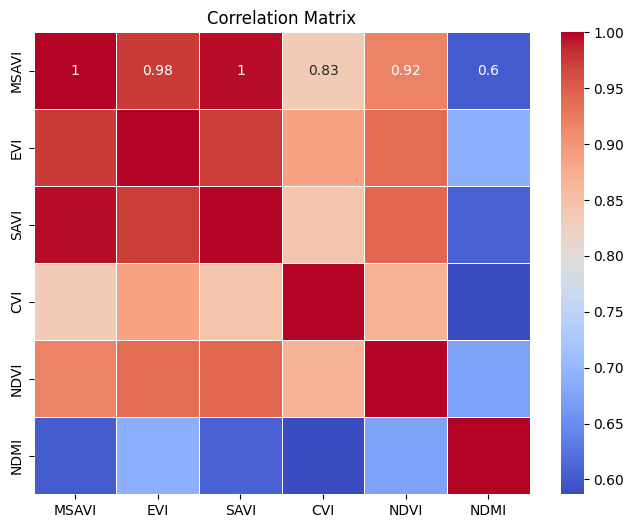

In [21]:
indices_corr_df = df[parser.get_indices()].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(indices_corr_df, annot=True, cmap="coolwarm", linewidths=0.7)
plt.title("Correlation Matrix")
plt.show()

In [22]:
indices_corr_df[indices_corr_df.abs() < corr_threshold]

,MSAVI,EVI,SAVI,CVI,NDVI,NDMI
MSAVI,NaN,NaN,NaN,NaN,NaN,0.601602
EVI,NaN,NaN,NaN,NaN,NaN,0.689477
SAVI,NaN,NaN,NaN,NaN,NaN,0.606225
CVI,NaN,NaN,NaN,NaN,NaN,0.586695
NDVI,NaN,NaN,NaN,NaN,NaN,0.674867
NDMI,0.601602,0.689477,0.606225,0.586695,0.674867,NaN


We can clearly see that all indices say the same info, except NDMI.
Since NDVI has no outliers, it remains

##### Feature selection

It is hard to select the features with most importance.

So, we train a feature selector model that tells which ones give the highest accuracy.

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV 

X_Y_map = {label: [] for label in parser.get_groundtruth_f()}

feature_selector = RFECV(LinearRegression())

for label in X_Y_map.keys():
    Data = df.dropna(subset=[label])
    X, Y = Data[parser.get_features()].to_numpy(), Data[label].to_numpy()
    fit = feature_selector.fit(X, Y)

    selected_f = feature_selector.get_feature_names_out(parser.get_features())
    X_Y_map[label] = list(selected_f)
    print(f"Found {feature_selector.n_features_} optimal features for label {label}")
    print(f'Removed: {set(parser.get_features()).difference(set(selected_f))}\n')

print(f'\n----------------------\n{X_Y_map}')

Found 1 optimal features for label C
Removed: {'EVI', 'NDMI', 'B:GREEN', 'NDVI', 'B:SWIR5', 'B:RED', 'CVI', 'B:BLUE', 'B:THERMAL', 'SAVI', 'MSAVI', 'B:SWIR7'}

Found 1 optimal features for label N
Removed: {'EVI', 'NDMI', 'B:GREEN', 'NDVI', 'B:SWIR5', 'CVI', 'B:BLUE', 'B:THERMAL', 'SAVI', 'B:NIR', 'MSAVI', 'B:SWIR7'}

Found 1 optimal features for label S
Removed: {'EVI', 'NDMI', 'B:GREEN', 'NDVI', 'B:SWIR5', 'B:RED', 'CVI', 'B:BLUE', 'B:THERMAL', 'SAVI', 'MSAVI', 'B:SWIR7'}

Found 1 optimal features for label Cu
Removed: {'EVI', 'NDMI', 'B:GREEN', 'NDVI', 'B:SWIR5', 'B:RED', 'CVI', 'B:BLUE', 'B:THERMAL', 'B:NIR', 'MSAVI', 'B:SWIR7'}

Found 1 optimal features for label Mo
Removed: {'EVI', 'NDMI', 'B:GREEN', 'NDVI', 'B:SWIR5', 'CVI', 'B:BLUE', 'B:THERMAL', 'SAVI', 'B:NIR', 'MSAVI', 'B:SWIR7'}

Found 1 optimal features for label Z
Removed: {'EVI', 'NDMI', 'B:GREEN', 'NDVI', 'B:SWIR5', 'B:RED', 'CVI', 'B:BLUE', 'B:THERMAL', 'B:NIR', 'MSAVI', 'B:SWIR7'}

Found 13 optimal features for label 

Addittionaly, one can compute the correlation of each label with all features, and investigate if there is any association

In [26]:
for label in parser.get_groundtruth_f():
    aux_df = df[parser.get_features() + [label]].corr()[label].abs()
    print(aux_df[aux_df > 0.30])
    print('--------------')

EVI        0.353302
SAVI       0.309297
CVI        0.352482
NDVI       0.385937
NDMI       0.361420
B:SWIR7    0.303233
C          1.000000
Name: C, dtype: float64
--------------
MSAVI      0.301877
EVI        0.347819
SAVI       0.305325
CVI        0.352430
NDVI       0.368992
NDMI       0.336683
B:SWIR7    0.317681
N          1.000000
Name: N, dtype: float64
--------------
S    1.0
Name: S, dtype: float64
--------------
Cu    1.0
Name: Cu, dtype: float64
--------------
Mo    1.0
Name: Mo, dtype: float64
--------------
Z    1.0
Name: Z, dtype: float64
--------------
MSAVI      0.358044
EVI        0.417963
SAVI       0.378457
CVI        0.438969
NDVI       0.468013
NDMI       0.362377
B:SWIR7    0.433915
pH         1.000000
Name: pH, dtype: float64
--------------
P    1.0
Name: P, dtype: float64
--------------
K    1.0
Name: K, dtype: float64
--------------
Ca    1.0
Name: Ca, dtype: float64
--------------
Mg    1.0
Name: Mg, dtype: float64
--------------
Fe    1.0
Name: Fe, dtype: flo

In [27]:
Y_corr_df = {l: {} for l in parser.get_groundtruth_f()}
for label in parser.get_groundtruth_f():
    aux_df = df[parser.get_features() + [label]].corr()[label].abs()
    Y_corr_df[label] = aux_df[aux_df > 0.30].index
    Y_corr_df[label] = {} if len(Y_corr_df[label]) == 1 else set(Y_corr_df[label][:-2])
    print(label, Y_corr_df[label])
    print('---------------')

C {'EVI', 'NDMI', 'NDVI', 'CVI', 'SAVI'}
---------------
N {'EVI', 'NDMI', 'NDVI', 'CVI', 'SAVI', 'MSAVI'}
---------------
S {}
---------------
Cu {}
---------------
Mo {}
---------------
Z {}
---------------
pH {'EVI', 'NDMI', 'NDVI', 'CVI', 'SAVI', 'MSAVI'}
---------------
P {}
---------------
K {}
---------------
Ca {}
---------------
Mg {}
---------------
Fe {}
---------------
Mn {}
---------------
Cec {}
---------------


completely off

#### Data specification for each label

In [49]:
df_mapper = {label: df[list(set(X_Y_map[label]).union(Y_corr_df[label])) + [label]] for label in parser.get_groundtruth_f()}
print('Df:')
df_mapper['Ca']

Df:


,EVI,SAVI,B:NIR,MSAVI,Ca
0,0.430648,0.516231,0.326123,0.522193,2366.740
1,0.039465,0.085820,0.348632,0.080129,NaN
2,0.098452,0.174737,0.237731,0.154093,NaN
3,0.053461,0.105913,0.248676,0.093745,2849.688
4,0.079284,0.145009,0.231056,0.127051,4745.472
...,...,...,...,...,...
1144,0.287844,0.359052,0.201933,0.326704,30885.168
1145,0.346199,0.444927,0.300218,0.431739,8835.268
1146,0.177301,0.260645,0.161653,0.221364,6644.260
1147,0.380409,0.469828,0.292573,0.460600,2536.340


#### Geospatial analysis

In [45]:
location_df = pd.DataFrame(columns=['Lat', 'Long'], data=[[tsp.location.x[0], tsp.location.y[0]] for tsp in parser.get_tspatches()])

map_center = [location_df['Lat'].mean(), location_df['Long'].mean()]
m = folium.Map(location=map_center, zoom_start=2)  # Adjust the zoom level as needed

# Add circles to the map for each place in the DataFrame
for index, row in location_df.iterrows():
    folium.CircleMarker(
        location=[row['Lat'], row['Long']],
        radius=2,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.5
    ).add_to(m)
m

## Experiment

In [31]:
parser.set_df(df_mapper['C'])
parser.df

,EVI,CVI,NDMI,NDVI,SAVI,B:NIR,C
0,0.430648,6.015018,0.331379,0.826785,0.516231,0.326123,68700.0
1,0.039465,1.954421,-0.135294,0.102472,0.085820,0.348632,NaN
2,0.098452,2.824722,0.005144,0.272481,0.174737,0.237731,NaN
3,0.053461,2.211105,-0.167751,0.152387,0.105913,0.248676,NaN
4,0.079284,2.613178,-0.125625,0.224851,0.145009,0.231056,NaN
...,...,...,...,...,...,...,...
1144,0.287844,3.901621,0.402364,0.767342,0.359052,0.201933,483800.0
1145,0.346199,4.293618,0.252910,0.722049,0.444927,0.300218,405200.0
1146,0.177301,3.463032,0.266247,0.605554,0.260645,0.161653,385200.0
1147,0.380409,7.800481,0.277436,0.793990,0.469828,0.292573,32700.0


### Model selection

In [41]:
 # Available models
GBR = tstk.GradientBoostingRegressor()
MLPR = tstk.MLPRegressor(max_iter=int(1e6))
PLSR = tstk.PLSRegressor()
RFR = tstk.RandomForestRegressor()
SVR = tstk.SupportVectorRegression()
SL_models = [GBR, MLPR, PLSR, RFR, SVR]

CoReg = tstk.CoReg()
SSL_models = [CoReg]

# Other algs
cv = tstk.KFold()

exp = tstk.Experiment(name='test', parser=parser, models=SL_models + [CoReg], Y_name='C')

### Model fitting and prediction

In [42]:
exp.execute()

{'SL': [Result: [
  	Train(X_train):  (300, 13)
  	Test(X_test):  (201, 13)
  	Parameters(θ):  {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
  	Prediction(Y_^): (201,)
  ],
  Result: [
  	Train(X_train):  (300, 13)
  	Test(X_test):  (201, 13)
  	Parameters(θ):  {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 1000000, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum

### Model evaluation

In [43]:
exp.calculate_metrics()

,algorithm,run,mae,n_mae,rmse,n_rmse
0,GradientBoostingRegressor,1,58447.286256,0.113292,1.006422e+05,0.195081
1,MLPRegressor,2,63842.965007,0.123751,9.973044e+04,0.193314
2,PLSRegressor,3,70465.583906,0.136588,1.105526e+05,0.214291
3,RandomForestRegressor,4,53519.531576,0.103740,9.058439e+04,0.175585
4,SupportVectorRegression,5,56574.622111,0.109662,1.281314e+05,0.248365
0,CoReg,1,60111.473573,0.113055,1.167111e+10,21950.546815
